|  |  |
| ----------- | ----------- |
| Author:| Benjamin Stepin |
| Affiliation:| IMOS-AODN |
| e-mail:| benjamin.stepin@utas.edu.au |
| Date of creation:| 9th May., 2024|


## Required packages

- xarray==2024.3.0
- pandas==2.2.2
- s3fs==2024.3.1
- mplcursors==0.5.3
- cartopy==0.23.0
- matplotlib==3.8.4
- ipympl==0.9.4 (this is for the #matplotlib functionality)
- h5netcdf==1.3.0

In [1]:
#this adds functionality for zooming in on data on the map.
%matplotlib widget 

import pandas as pd
import xarray as xr
import mplcursors
import s3fs
import os

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

## Create Functions

### load_wod_data()
This creates a function that can be called for any country or year. The keyboard inputs are year in format YYYY, and country in form string. (can handle spaces) up to 15 chars. eg "united states" not "united states of america"

### plot_wod_map()
This function plots the extracted data onto a map in order to visualise where the datasets are

In [33]:
def load_wod_data(year, dataset=None, country=None):
    dfs = []

    # Path to the WOD s3 bucket (this is an open bucket)
    s3_path = f's3://noaa-wod-pds/{year}/'

    # List all files in the S3 directory
    fs = s3fs.S3FileSystem(anon=True)
    files = fs.ls(s3_path)

    # If dataset is specified, check if it exists in the list of files
    if dataset:
        file_name = f'wod_{dataset}_{year}.nc'
        file_path = f'noaa-wod-pds/{year}/{file_name}'  # Add s3:// prefix
        if file_path not in files:
            print(f"Dataset '{dataset}' not found for the year {year}.")
            return None
        files = [file_path]

    # Iterate through each file in the directory to combine all datasets for a particular year and country
    for file in files:
        with fs.open(file, 'rb') as f:
            ds = xr.open_dataset(f)

            # In this case we're interested in the country, what type of dataset it is (eg, xbt), lat lon and date
            variables = ['Access_no', 'Project', 'originators_cruise_identifier', 'Platform', 'country', 'dataset', 'lat', 'lon', 'date']

            # Check if 'Institute' exists in the dataset so we know which institute is responsible for the dataset, not not all WOD files have this variable.
            if 'Institute' in ds.variables:
                variables.append('Institute')

            df = ds[variables].to_dataframe()
            if 'time' in df.columns:
                df.drop(columns=['time'], inplace=True)

            # All the variables come through as byte strings so we need to decode this to readable format
            for col in df.columns:
                if isinstance(df[col][0], bytes):
                    df[col] = df[col].str.decode('utf-8')

            # Add the 'year' column with the value from the file name
            df.insert(0, 'year', int(year))

            # Filter data by country if specified
            if country is not None:
                df = df[df['country'].str.upper() == country.upper()]

            # Filter data by dataset if specified
            if dataset is not None:
                df = df[df['dataset'].str.upper() == dataset.upper()]

            # Append the DataFrame to the list
            dfs.append(df)

    # Concatenate all DataFrames into a single DataFrame
    combined_df = pd.concat(dfs, ignore_index=True)
    
    return combined_df


# Function to count the number of unique "Access_no" values
def count_unique_access_no(df):
    return df['Access_no'].nunique()

# Function to count the number of unique "Access_no" values
def count_unique_OCI(df):
    return df['originators_cruise_identifier'].nunique()

def plot_wod_map(df):
    # Format desired_country with first letter uppercase and the rest lowercase
    formatted_country = desired_country.capitalize()

    # Create a new figure
    plt.figure(figsize=(10, 6))

    # Define the map projection
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Plot coastlines
    ax.coastlines()

    # Define unique dataset types
    dataset_types = df['dataset'].unique()

    # Define colors for each dataset type
    colors = plt.cm.tab10.colors[:len(dataset_types)]

    scatter_plots = []  # Collect scatter plots here

    # Plot data points for each dataset type
    for i, dataset_type in enumerate(dataset_types):
        dataset_df = df[df['dataset'] == dataset_type]
        scatter = ax.scatter(dataset_df['lon'], dataset_df['lat'], transform=ccrs.PlateCarree(), s=10, color=colors[i], label=dataset_type)
        scatter_plots.append(scatter)  # Add scatter plot to the list

    # Add gridlines
    ax.gridlines(draw_labels=True)

    # Put a legend below current axis
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3)

    # Set bounds if you would lke to have a world map
    ax.set_ylim([-80, 80])
    ax.set_xlim([-180, 180])

    # Add title and labels
    ax.set_title(f'WOD data from {formatted_country} for {desired_year}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Enable click functionality for all scatter plots
    mplcursors.cursor(scatter_plots).connect("add", lambda sel: sel.annotation.set_text(df.iloc[sel.target.index]))

    # Show the plot
    plt.show()


## Check WOD for data products

In [28]:
# Example usage:
desired_year = input("Enter the desired year: ")
desired_country = input("Enter the desired country (leave blank for all countries): ").upper()
desired_dataset = input("Enter the desired dataset (eg XBT, CTD etc. or press Enter to include all datasets): ").lower()
dataframe = load_wod_data(desired_year, dataset=desired_dataset, country=desired_country)
print(dataframe)

Enter the desired year:  2019
Enter the desired country (leave blank for all countries):  australia
Enter the desired dataset (eg XBT, CTD etc. or press Enter to include all datasets):  xbt


      year  Access_no Project originators_cruise_identifier  \
0     2019   187329.0                                  935N   
1     2019   239558.0                                    41   
2     2019   239558.0                                    41   
3     2019   239558.0                                    41   
4     2019   239558.0                                    41   
...    ...        ...     ...                           ...   
2315  2019   239558.0                                    15   
2316  2019   239558.0                                         
2317  2019   239558.0                                         
2318  2019   239558.0                                         
2319  2019   239558.0                                         

                                               Platform    country dataset  \
0     SWAN RIVER BRIDGE (Cont.ship; call sign 9V8218...  AUSTRALIA     XBT   
1     NORTHWEST SANDERLING (LNG Tanker;call sign VNV...  AUSTRALIA     XBT   
2     NOR

## Plot the data on a world map

This is an interactive map to identify particular casts from the WOD.

Number of unique Access_numbers within the WOD dataset: 6
Number of unique Cruises (eg. voyages) within the WOD dataset: 21


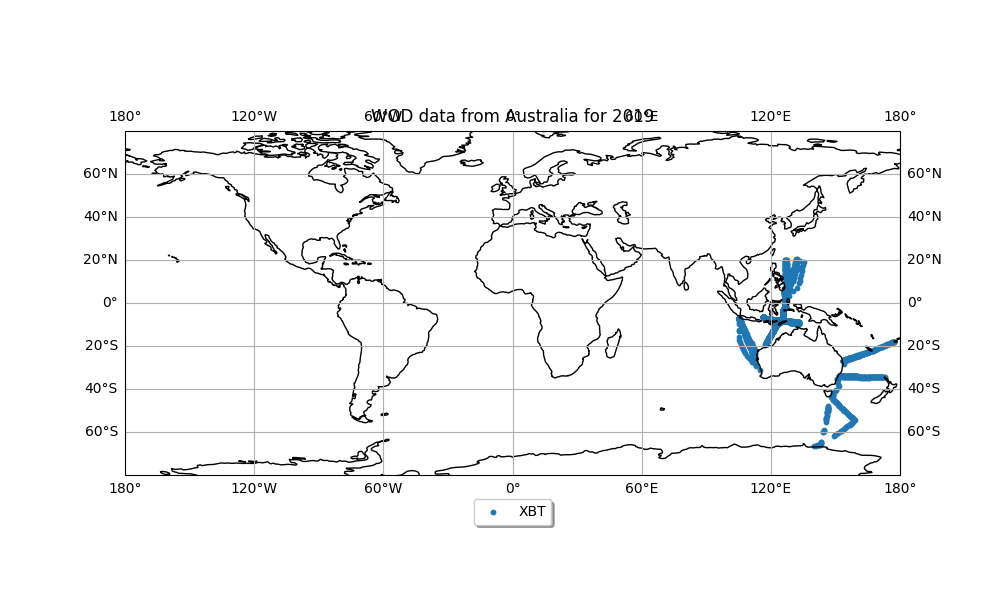

In [34]:
print (f'Number of unique Access_numbers within the WOD dataset: {count_unique_access_no(dataframe)}')
print (f'Number of unique Cruises (eg. voyages) within the WOD dataset: {count_unique_OCI(dataframe)}')
plot_wod_map(dataframe)